In [26]:
from fatiando import gridder, utils, mesher
from fatiando.gravmag import polyprism
from fatiando.vis import mpl, myv
import cPickle as pickle
import numpy as np
from numpy.testing import assert_almost_equal as aae
from fatiando import utils, gridder
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from matplotlib import rcParams
from numpy.linalg import inv
from timeit import default_timer as time
%matplotlib inline

In [27]:
# Create a regular grid at 0m height
bounds = [-2000, 2000, -2000, 2000, 0, 3000]
area = bounds[:4]
depths = [0, 3000] 
shape = (100, 100)
xi, yi, zi = gridder.regular(area, shape, z=0.)

# Polygonal Prism model
verts1 = [[-500, -500], [500, -500], [500, 500], [-500, 500]]

model = [mesher.PolygonalPrism(verts1, 1500, 2200, props={'density':2670})]

# Vertical component of the gravitational atraction with noise at z=0
gz = dict()
gz['prism_gz'] = utils.contaminate(polyprism.gz(xi, yi, zi, model), 0.1, seed=0)

In [28]:
# Gravitational constant
G = 6.67408 * 10**(-11)

# Equivalent Layer at z=700
shapej = (50, 50)
areaj = [-2000, 2000, -2000, 2000]
xj, yj, zj = gridder.regular(areaj, shapej, z=700)

N = shape[0]*shape[1]
M = shapej[0]*shapej[1]

In [29]:
# Calculo da matriz de sensibilidade
A = np.empty((N, M), dtype=np.float)
s = time()
for i in xrange (N):
        a = (zj-zi[i])
        b = (xi[i]-xj)
        c = (yi[i]-yj)
        A[i] = a/(b*b+c*c+a*a)**(1.5)
        
e = time()
tcpu = e - s
print '%5.3f seconds' %tcpu
A = G*A
A.shape

1.580 seconds


(10000L, 2500L)

In [30]:
# Estimation of parameter p (mass)
if N >= M:
    #overdetermined
    p = dict()
    mu = 10**(-2)
    I = np.identity(M)
    trace = np.trace(A.T.dot(A))/M
    AI = inv(A.T.dot(A)+mu*trace*I)
    p['eq_layer'] = (AI.dot(A.T)).dot(gz['prism_gz'])
else:
    #underterminated
    p = dict()
    mu = 10**(-2)
    I = np.identity(N)
    trace = np.trace(A.T.dot(A))/M
    AI = inv(A.dot(A.T)+mu*trace*I)
    p['eq_layer'] = (A.T.dot(AI)).dot(gz['prism_gz'])

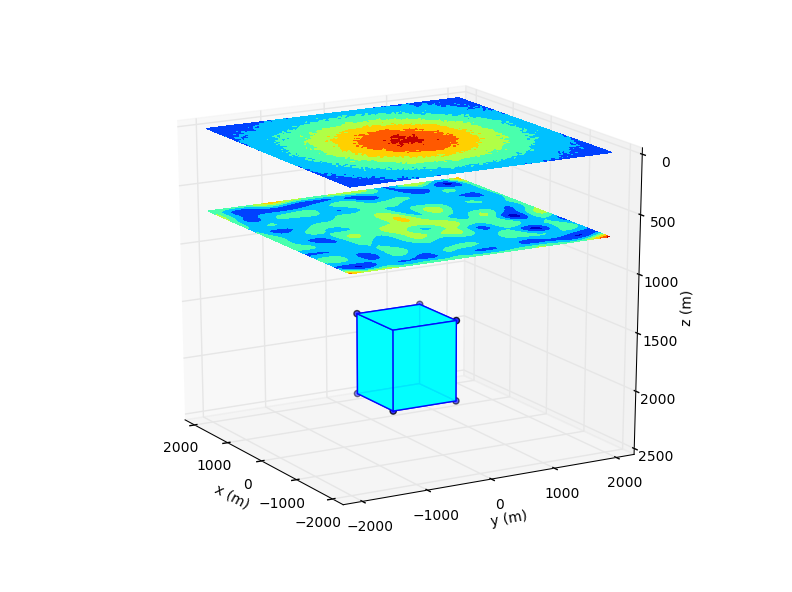

In [31]:
rcParams['contour.negative_linestyle'] = 'solid'

plt.close('all')
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')

#ranges = np.max(np.abs([np.min(gz['prism_gz']), np.max(gz['prism_gz'])]))
#levels = MaxNLocator(nbins=16).tick_values(-ranges, ranges)
#cmap = plt.get_cmap('seismic')
#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)

#vertical gravitational atraction plot
ax.contourf(xi.reshape(shape), yi.reshape(shape), gz['prism_gz'].reshape(shape),
                zdir='z', offset=0, cmap='jet')

# vertices of a prism
v = np.array([[-500, -500, 2200], [-500, 500, 2200], [500, 500, 2200],  [500, -500, 2200], 
              [-500, -500, 1500], [-500, 500, 1500], [500, 500, 1500],  [500, -500, 1500]])
ax.scatter3D(v[:, 0], v[:, 1], v[:, 2])

# generate list of sides of our prism
verts = [[v[0],v[1],v[2],v[3]], [v[0],v[1],v[5],v[4]], [v[1],v[2],v[6],v[5]],
         [v[2],v[3],v[7],v[6]], [v[3],v[0],v[4],v[7]], [v[4],v[5],v[6],v[7]]]

# plot sides
ax.add_collection3d(Poly3DCollection(verts, 
 facecolors='cyan', linewidths=1, edgecolors='b', alpha=.9))

# density plot
ax.contourf(xj.reshape(shapej), yj.reshape(shapej), p['eq_layer'].reshape(shapej),
                zdir='z', offset=700, cmap='jet')

#change size projection
x_scale=1
y_scale=1
z_scale=1.3
scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0
def short_proj():
  return np.dot(Axes3D.get_proj(ax), scale)
ax.get_proj=short_proj

#labels
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlim(0,2500)
ax.set_zlabel('z (m)')

#visualization angle
ax.view_init(200, 30)

plt.tight_layout(True)

#plt.savefig('figures/3dmodel_eq.jpg', dpi=300)

plt.show()